# ARIMA Prediction Model

Team Name: KANDY

Date: November 06, 2022

Project: Analyzing Information on Car Collision in Canada

Competition: HACKED(beta) 2022 at the University of Alberta

Author: Jamie Lee

Team Members: Min Joh, Jamie Lee, Taekwan Yoon, Yongbin Kim, Dohyun Kim

Description of file:

This Jupyter Notebook predicts of the number of collisions in Canada from 1999 to 2019. Data is referenced from National Collision Database Online, and used to train ARIMA model. ARIMA model is Autoregressive Integrated Moving Average Model that forecasts and analyes time series model based on its past values. 


## 1.Setups

### 1.0 Importing Modules and Data

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(foler_path, filename):
    data = os.path.join(foler_path, filename)
    dataframe = pd.read_csv(data)
    return dataframe

In [ ]:
data_path = '/content/drive/Shareddrives/KANDY-hacked-beta/Data_Sets'
collision_df = load_data(data_path, "canada_collisions_statistics.csv")
collision_df = collision_df.rename(columns= {"Unnamed: 0": "Year", "Measures": "Month"}).iloc[1: , :]
collision_df.insert(0, "Date", pd.to_datetime(collision_df['Year'].astype(str) + collision_df['Month'], format='%Y%B'))
collision_df['Date'] = pd.to_datetime(collision_df['Date']) # making sure 'Date' is really a 'Date'
collision_df = collision_df.set_index('Date')
collision_df.head(20)

,Year,Month,Number of collisions,Number of vehicles,Number of persons,Number of injured,Number of fatalities
Date,,,,,,,
1999-01-01,1999,January,12365.0,22709.0,33502.0,17530.0,163.0
1999-02-01,1999,February,9915.0,17784.0,26508.0,14128.0,196.0
1999-03-01,1999,March,10885.0,19772.0,29408.0,15548.0,219.0
1999-04-01,1999,April,10427.0,19141.0,28359.0,15073.0,190.0
1999-05-01,1999,May,12904.0,23626.0,35425.0,18518.0,266.0
1999-06-01,1999,June,13462.0,24983.0,36972.0,19555.0,267.0
1999-07-01,1999,July,13807.0,25199.0,38750.0,20632.0,291.0
1999-08-01,1999,August,14003.0,25701.0,39107.0,20638.0,294.0
1999-09-01,1999,September,13343.0,24804.0,36418.0,19140.0,257.0


## 2. Modeling

### 2.0 Plot Data

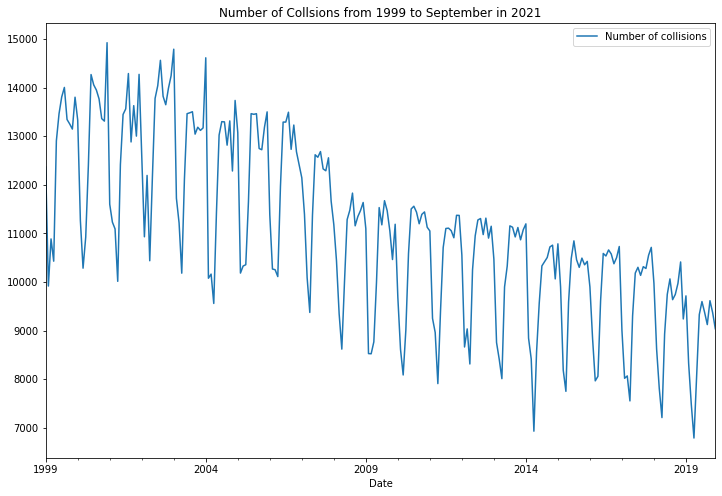

In [ ]:
collision_df.plot(y='Number of collisions', kind='line', figsize=(12, 8), title="Number of Collsions from 1999 to September in 2021")
plt.show()

### 2.1 Checking Stationarity

Before we start ARIMA modeling, we have to check if the data is *stationary or not*; i.e. whether the data have **trend** or **seasonal** **effects**. 

To check the stationarity, we can use *Augmented Dicky Fuller test*, which tests the null hypothesis that unit root is present in a time sereis data. 

If the null hypothesis is **rejected**; test-statistic < critical value and p-value < 0.05 (95% confidence level), meaning the time series is **stationary**.

If it is **not rejected**, we can say that the time series is **not stationary**. 

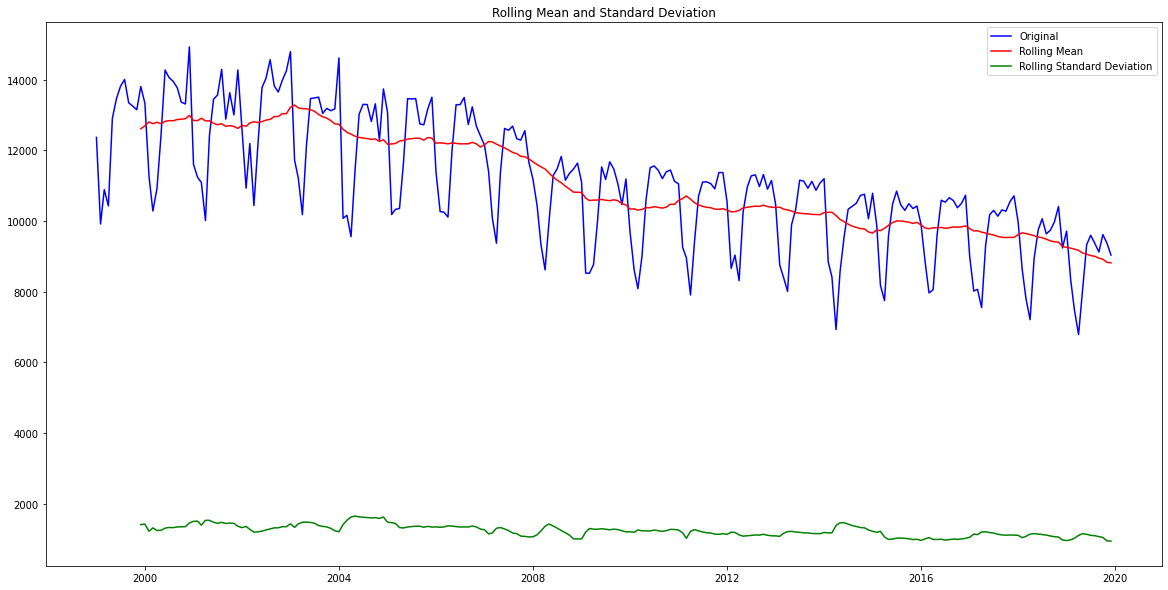

Results of Dickey Fuller Test
Test Statistics            -0.127866
p-value                     0.946591
No. of lags used           15.000000
Number of observations    236.000000
Critical value (1%)        -3.458366
Critical value (5%)        -2.873866
Critical value (10%)       -2.573339
dtype: float64


In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_adf(date):
  moving_avg = date.rolling(12).mean()
  moving_std = date.rolling(12).std()
  plt.figure(figsize=(20,10))
  plt.plot(date, color="blue", label="Original")
  plt.plot(moving_avg, color="red", label="Rolling Mean")
  plt.plot(moving_std, color="green", label="Rolling Standard Deviation")
  plt.title("Rolling Mean and Standard Deviation")
  plt.legend()
  plt.show(block=False)
  print('Results of Dickey Fuller Test')
  adft = adfuller(date, autolag="AIC")
  result = pd.Series(adft[0:4], index = ['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations'])
  for key, value in adft[4].items():
    result['Critical value (%s)'%key]=value
  print(result)

test_adf(collision_df['Number of collisions'])

As the resulted p-value is greater than 0.05, we cannot reject the null hypothesis. Therefore, the data is **not** **stationary**. 

Since the data is not stationary, we have to separate the trend and seasonality. 

### 2.2 Separate Trend and Seasonality

<Figure size 432x288 with 0 Axes>

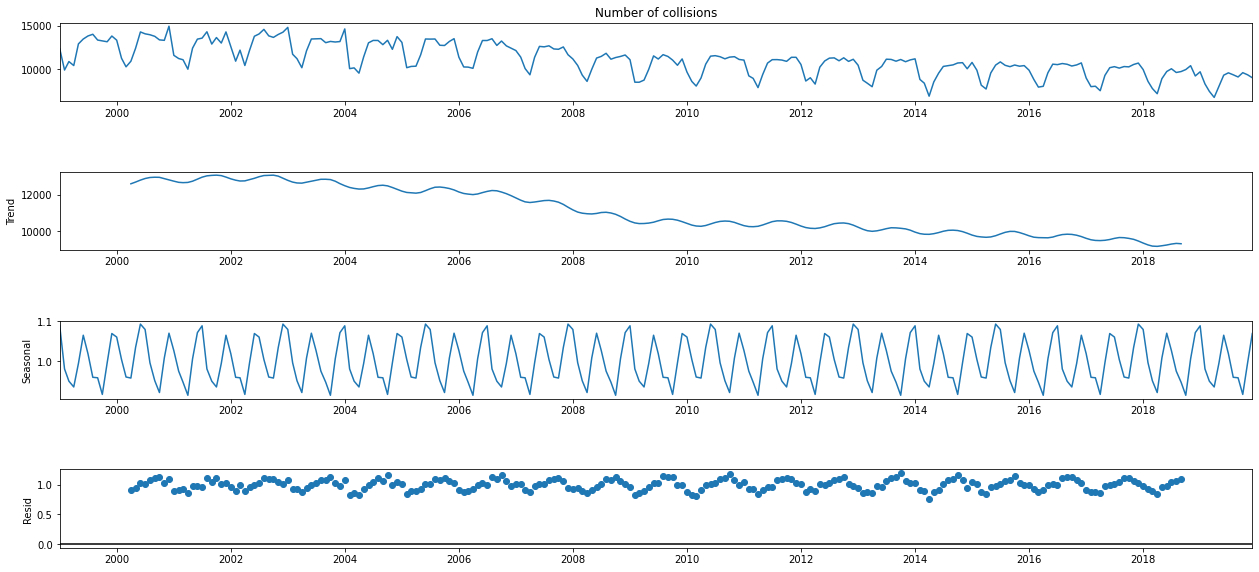

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(collision_df['Number of collisions'], model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot().set_size_inches(20,9)

### 2.3 Convert Data to Stationary Data

To convert non-stationary data to stationary data, we can take the log of stock price.

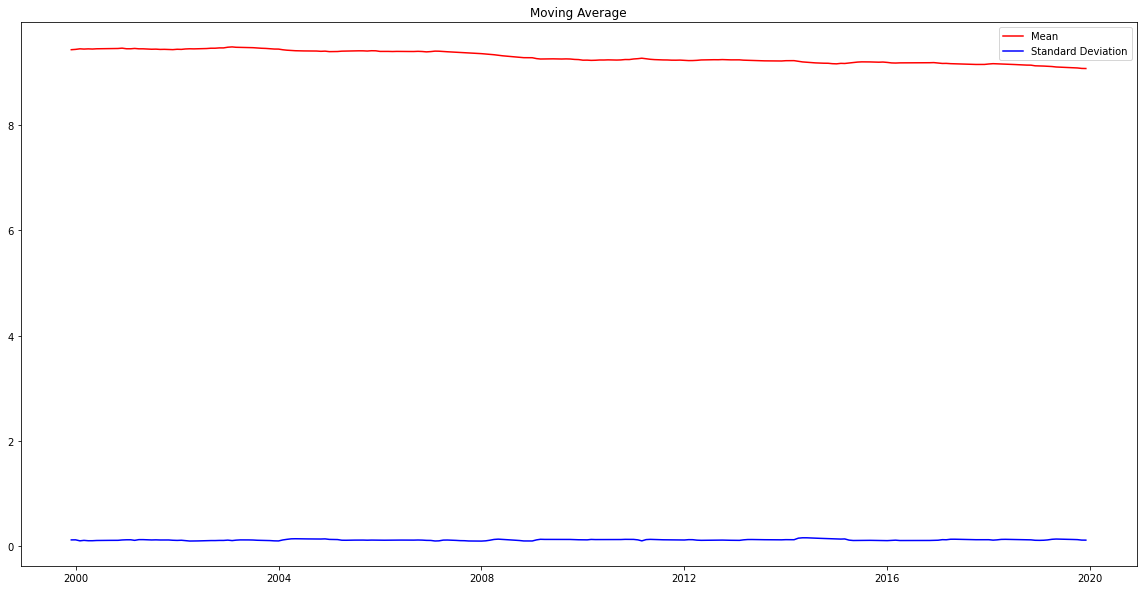

In [ ]:
from pylab import rcParams as rc

close_data = collision_df['Number of collisions']
rc['figure.figsize'] = 20, 10
log_data = np.log(close_data)
moving_avg = log_data.rolling(12).mean()
std = log_data.rolling(12).std()
plt.title('Moving Average')
plt.plot(moving_avg, color='red',label='Mean')
plt.plot(std, color='blue',label='Standard Deviation')
plt.legend()
plt.show()

From above graph, we subtract the moving average and apply ADF test.

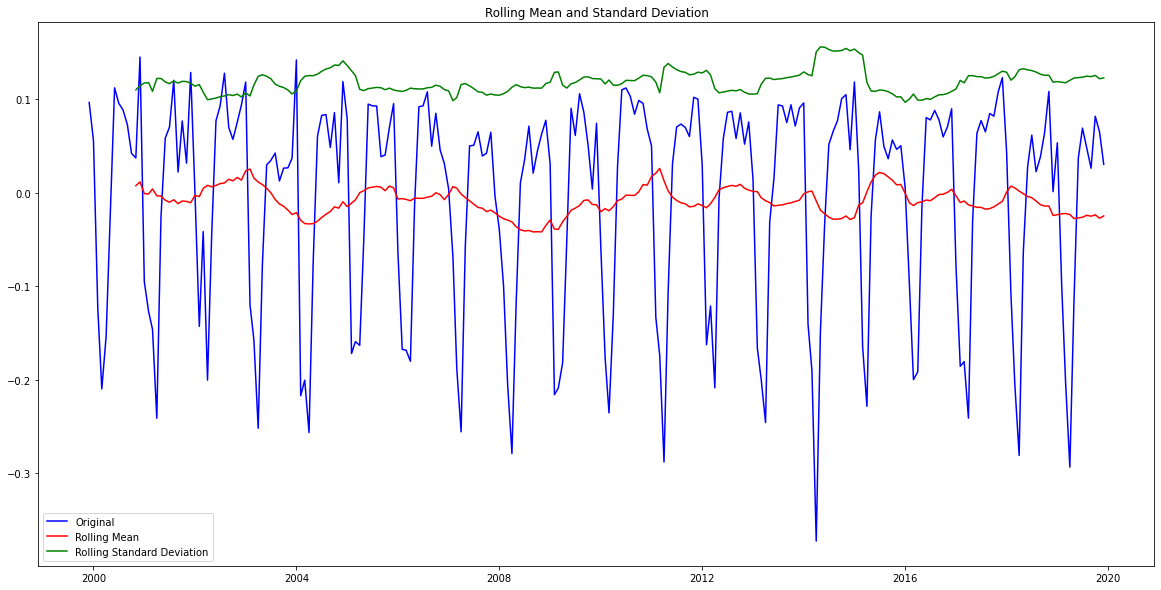

Results of Dickey Fuller Test
Test Statistics            -4.229679
p-value                     0.000587
No. of lags used           14.000000
Number of observations    226.000000
Critical value (1%)        -3.459620
Critical value (5%)        -2.874415
Critical value (10%)       -2.573632
dtype: float64


In [ ]:
log_data_minus_mean = log_data - moving_avg
log_data_minus_mean.dropna(inplace=True)
test_adf(log_data_minus_mean)

Now, above result shows that p value is NOT greater than 0.05; p-value < 0.05. So, we can now reject the null hypothesis and states that the data is stationary. 

### 2.4 Train-Test Split

Split train test data by ratio of 80:20.

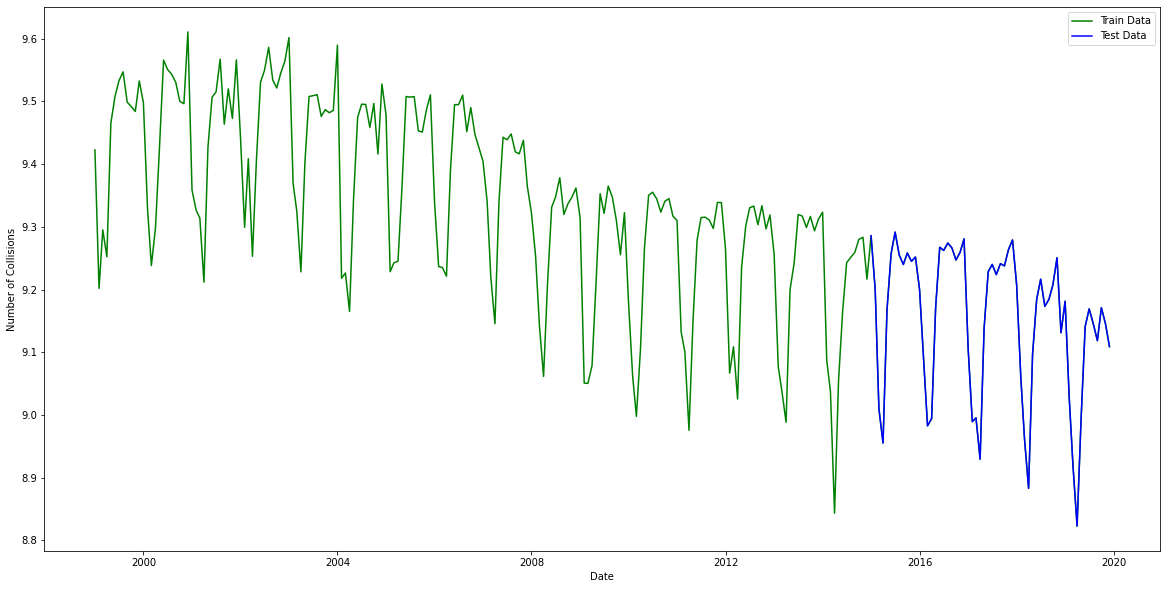

In [ ]:
train_data, test_data = log_data[:int(len(log_data)*0.8)], log_data[int(len(log_data_minus_mean)*0.8):]
plt.figure(figsize=(20,10))
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.plot(log_data, 'green', label='Train Data')
plt.plot(test_data, 'blue', label='Test Data')
plt.legend()
plt.show()

### 2.5 Apply ARIMA Model

In [ ]:
pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 9.9 MB 35.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


We use auto_arima function to find best p, d, and q value for the data. 

In [ ]:
from pmdarima.arima import auto_arima

model_auto_arima = auto_arima(train_data, start_p=0, start_q=0,
                              test='adf',
                              max_p=7, max_q=7,
                              m=1,
                              d=None,
                              seasonal=False,
                              start_P=0,
                              D=0,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1470.510, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-348.825, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-346.845, Time=0.19 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-348.282, Time=0.41 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.64 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-371.568, Time=1.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=1.48 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-392.617, Time=1.55 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-390.409, Time=0.54 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-399.893, Time=0.58 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=-405.133, Time=0.59 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-405.999, Time=0

According to above results, we can use p = 4, d = 0, q = 2 as an optimal order. 

### 2.6 Create ARIMA model

In [ ]:
pip install statsmodels==0.12.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 5.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pmdarima 2.0.1 requires statsmodels>=0.13.2, but you have statsmodels 0.12.2 which is incompatible.


In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(4,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be us

                               ARMA Model Results                               
Dep. Variable:     Number of collisions   No. Observations:                  201
Model:                       ARMA(4, 2)   Log Likelihood                 221.481
Method:                         css-mle   S.D. of innovations              0.077
Date:                  Sun, 06 Nov 2022   AIC                           -426.961
Time:                          08:32:40   BIC                           -400.535
Sample:                      01-01-1999   HQIC                          -416.268
                           - 09-01-2015                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         -4.5123        nan        nan        nan         nan         nan
ar.L1.Number of collisions     2.4836        nan        nan        

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1521: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


### 2.7 Prediction

Referred to https://www.statsmodels.org/v0.11.1/generated/statsmodels.tsa.arima_model.ARMAResults.forecast.html
for function arima_model.forecast() parameters and returns.

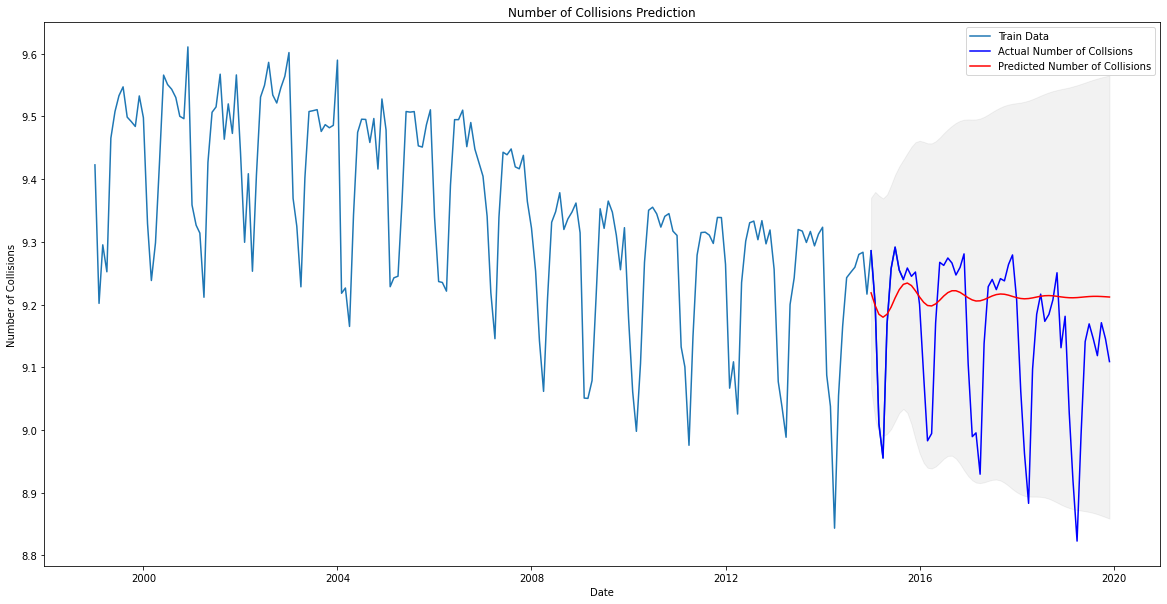

In [ ]:
forecast, stderr, conf = model_fit.forecast(60, alpha=0.05)
fc_series = pd.DataFrame(forecast, index = test_data.index, columns=['Prediction'])
# fc_series = pd.Series(forecast, index=test_data.index) 

# calculate forecast (log values) to actual output
actual = 2.718 ** forecast
actual = pd.DataFrame(actual, index = test_data.index, columns=['Actual Value'])

lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(20, 10))
plt.plot(train_data, label='Train Data')
plt.plot(test_data, color='blue', label='Actual Number of Collsions')
plt.plot(fc_series, color='red', label='Predicted Number of Collisions')
plt.fill_between(lower_series.index, lower_series, upper_series, color='black', alpha=0.05)
plt.title('Number of Collisions Prediction')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()

## 3. Performance of ARIMA

In order to evalute ARIMA model performance, we can use Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE).


Referred to https://towardsdatascience.com/measures-performance-for-a-time-series-model-ets-or-arima-18b0a3e91e83 

In [ ]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test_data, forecast)
print('Mean Squared Error:', str(mse))
mae = mean_absolute_error(test_data, forecast)
print('Mean Absolute Error:', str(mae))
rmse = math.sqrt(mean_squared_error(test_data, forecast))
print('Root Mean Squared Error:', str(rmse))
mape = np.mean(np.abs(forecast - test_data) / np.abs(test_data))
print('Mean Aboslute Percentage Error:', str(mape))

Mean Squared Error: 0.016351410935297787
Mean Absolute Error: 0.09018630432229688
Root Mean Squared Error: 0.12787263560002893
Mean Aboslute Percentage Error: 0.009975203534036895
